<a href="https://colab.research.google.com/github/Albmargar1/ClickbaitDetector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name = 'Index'> </a> <font color='orange'> Índice </font>

* [Notas iniciales](#NotasIniciales)
* [Instalación del entorno](#setup)
* [Pipeline](#Pipeline)
* [Análisis descriptivo de los datos](#preanalysis)
* [Fine-tuning](#Fine-tuning):
  * 'postText' (Texto del tweet)
    * [Búsqueda de hiperparámetros en BERT](#M1)
    * [Búsqueda de hiperparámetros en RoBERTa](#M2)
    * [Búsqueda de hiperparámetros en XLM-RoBERTa](#M3)
  * 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace)
    * [Búsqueda de hiperparámetros en BERT](#M4)
    * [Búsqueda de hiperparámetros en RoBERTa](#M5)
    * [Búsqueda de hiperparámetros en XLM-RoBERTa](#M6)
  * 'postText' (Texto del tweet) + 'targetParagraphs' (Texto del enlace)
    * [Búsqueda de hiperparámetros en Longformer](#M7)
* Evaluación del dataset para cada input y checkpoint correspondiente. 
  * Comparación con estado del arte
* [Análisis de errores](#errors)
* [Otras funciones](#Otros)
 * Subir checkpoint a HuggingFace
 * Liberar cache GPU

# <a name="NotasIniciales"> </a> <font color='orange'> Notas iniciales </font>

* Cambiar métricas, aparecen uans de GLUE

<font color='lightgreen'> Comentarios </font>
* # NO EJECUTAR TODAS LAS CELDAS A LA VEZ
* Este es el **archivo principal** donde se recogen todas las pruebas. **Cada prueba** posee una **configuración de parámetros difentes**, y llaman a una **única función** que recoge el pipeline global, controlando mediante flags qué funciones deben ejecutarse. Dichas funciones se encuentran todas en la carpeta 'utils'
* El índice contiene enlaces a cada sección para una navegación más cómoda. 

<font color='lightgreen'> Referencias </font>

* [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)

Quiero mencionar dos proyectos que hacen un trabajo muy parecido. Aunque obtengo ideas de ellos, considero que no hay plagio. Dichos trabajos servirán como referencia para comparar el modelo aquí desarrollado.
* [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT)
* [BERT, XLNet or RoBERTa: The Best Transfer Learning Model to Detect
Clickbaits](https://www.researchgate.net/publication/356276903_BERT_XLNet_or_RoBERTa_The_Best_Transfer_Learning_Model_to_Detect_Clickbaits)


# <font color='orange'> Parámetros </font>
Por comodidad, los parámetros a ajustar se encuentran en la parte superior del cuaderno.

In [1]:
default_config = {}

# Directories
default_config['train_dir'] = '/content/ClickbaitDetector/data/webis_train.csv'
default_config['test_dir'] = '/content/ClickbaitDetector/data/webis_test.csv'

# Descriptive analysis
default_config['logger_transformers'] = 'error'

# Dataset
default_config['train_val_split'] = 0.15
default_config['clip'] = [0.5,0.5]
default_config['inputs'] = ['postText']

# Hyperparameter search
default_config['n_trials'] = 4
default_config['hp'] = {'learning_rate': [1e-5, 5e-5], # Uniform sampling between min-max
                        'epochs': [1,3], # Pick int between min-max
                        'batch_size_train': [16, 32]} # Pick one

# Checkpoint
default_config['checkpoint'] = 'bert-base-uncased'
default_config['model_name'] = default_config['checkpoint'] + '-clickbait'
default_config['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
default_config['cloud_dir'] = 'Stremie/'+default_config['model_name'] + '-best'

[Volver al índice](#Index)
<a name=setup></a>
# <font color='orange'> Instalación del entorno </font>
Clonar el proyecto, instalar e importar dependencias.

In [2]:
!git clone https://github.com/Albmargar1/ClickbaitDetector -q

In [3]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 
     |████████████████████████████████| 596 kB 41.5 MB/s 
     |████████████████████████████████| 6.5 MB 35.7 MB/s 


In [4]:
!pip install datasets -q folium==0.2.1 # Tengo que especificar la versión de folium o da error al instalar la librería de datasets de Hugging Face

     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 69 kB 7.0 MB/s 
     |████████████████████████████████| 136 kB 41.7 MB/s 
     |████████████████████████████████| 1.1 MB 43.8 MB/s 
     |████████████████████████████████| 212 kB 43.6 MB/s 
     |████████████████████████████████| 127 kB 31.6 MB/s 
     |████████████████████████████████| 271 kB 15.0 MB/s 
     |████████████████████████████████| 94 kB 1.2 MB/s 
     |████████████████████████████████| 144 kB 10.9 MB/s 


In [5]:
!pip install optuna -q

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 7.2 MB/s 
     |████████████████████████████████| 210 kB 24.6 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 113 kB 34.8 MB/s 
     |████████████████████████████████| 150 kB 41.9 MB/s 


In [6]:
import sys
sys.path.append('/content/ClickbaitDetector/')

import optuna
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
import datasets
from datasets import load_metric
import torch
from torch.utils.data import DataLoader, SequentialSampler

from utils import data_processing, descriptive_analysis
from utils.Objective import Objective
from utils.bcolors import bcolors

[Volver al índice](#Index)
<a name='Pipeline'> </a>
# <font color='orange'> Pipeline </font>

In [7]:
def do_descriptive_analysis(data):
  descriptive_analysis.overall_info(data)
  descriptive_analysis.study_std(data)
  descriptive_analysis.probability_clickbait_per_tweet_count_words(data)
  descriptive_analysis.given_word_check_probability_clickbait(data)

In [8]:
def training(data_dir, p):
  data = data_processing.process_file(data_dir, p['inputs'])

  tokenizer = AutoTokenizer.from_pretrained(p['checkpoint'])
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  data_dic_train = data_processing.to_Dataset(data,
                                              clip=p['clip'],
                                              train_data=True, 
                                              train_val_split = p['train_val_split'])

  tokenized_dataset = data_processing.tokenize_dataset(data_dic_train, 
                                                      tokenizer)
    
  n_clickbaits_train = data_dic_train['train']['labels'].count(1)
  n_noclickbaits_train = data_dic_train['train']['labels'].count(0)
  prop_clickbait =  n_clickbaits_train / n_noclickbaits_train
    
  objective = Objective(p, tokenizer, data_collator, tokenized_dataset, prop_clickbait)
  study = optuna.create_study(study_name=p['model_name'], direction='maximize') 
  study.optimize(objective, n_trials=p['n_trials'], callbacks=[objective.callback]) 
  objective.best_model.save_pretrained(p['finetuned_model_dir'])
  tokenizer.save_pretrained(p['finetuned_model_dir'])

In [9]:
def model_performance(data_dir,p,checkpoint):
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # model
  model = AutoModelForSequenceClassification.from_pretrained(
          checkpoint, num_labels=2, return_dict=True)
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)
  model.eval()

  # metric
  metric = datasets.load_metric("glue", "mrpc")

  # load data
  data_test = data_processing.process_file(p['test_dir'], p['inputs'])
  data_dic_test = data_processing.to_Dataset(data_test,
                                              split=False)

  # tokenize
  tokenized_test = data_processing.tokenize_dataset(data_dic_test, 
                                                         tokenizer)

  tokenized_test = datasets.Dataset.from_dict({
        'input_ids': tokenized_test['test']['input_ids'],
        'token_type_ids': tokenized_test['test']['token_type_ids'],
        'attention_mask': tokenized_test['test']['attention_mask'],
        'labels': tokenized_test['test']['labels']})
  tokenized_test.set_format("torch")

  # create loader    
  test_loader = DataLoader(
        tokenized_test, batch_size=32, collate_fn=data_collator)

  # compute overall accuracy and F1-score
  for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

  results = metric.compute()
  print(results)

[Volver al índice](#Index)
<a name='preanalysis'></a>
# <font color='orange'> Análisis descriptivo </font>
Se realiza un análisis descriptivo básico, que incluye: 

*   Variabilidad de los anotadores
*   Probabilidad de clickbait en función del número de palabras por tweet
*   Probabilidad de que la palabra pertenezca a un clickbait


Se han truncado las últimas 5000 líneas del flujo de salida.
57
97
72
51
91
81
78
50
38
81
77
63
92
79
120
112
78
91
85
119
67
65
60
107
57
96
68
114
76
100
103
77
67
75
87
77
101
84
93
94
76
79
77
68
75
58
113
94
66
75
113
102
117
67
85
87
25
117
62
82
98
87
46
79
96
109
75
92
75
82
78
54
72
88
89
74
66
92
69
75
61
84
71
78
67
80
64
86
116
61
108
72
74
73
97
59
70
70
90
110
119
117
58
84
14
70
57
86
102
16
62
89
96
68
80
15
52
45
58
82
91
73
70
90
81
94
82
73
56
74
48
80
109
92
121
117
95
75
83
84
95
120
82
94
96
25
63
86
97
89
119
92
84
50
94
61
81
100
10
71
55
40
90
90
119
118
31
79
17
74
40
63
49
63
106
81
81
44
94
97
93
63
82
10
55
102
45
80
55
84
71
60
68
100
80
37
74
80
8
66
91
96
113
121
80
62
86
95
62
113
59
81
86
92
104
94
85
116
118
85
58
75
93
58
98
91
79
74
92
61
83
71
56
56
57
108
121
76
85
78
80
61
83
97
84
74
28
94
75
77
72
79
73
45
69
41
67
82
78
65
86
44
80
109
112
87
74
114
93
118
58
103
105
85
88
87
79
93
79
71
33
122
94
89
79
12
10
66
73
64
80
93
96
80
120
57
51
10

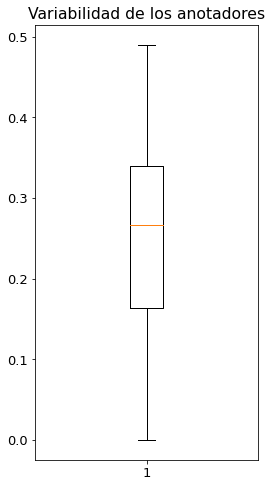

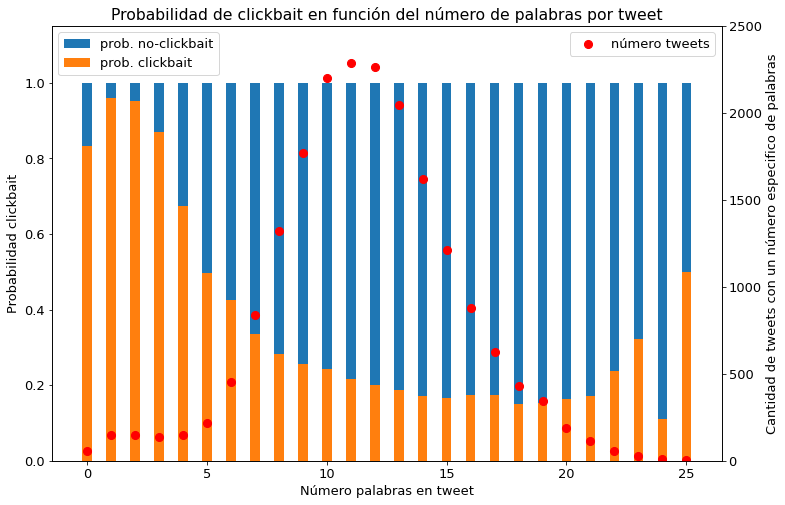

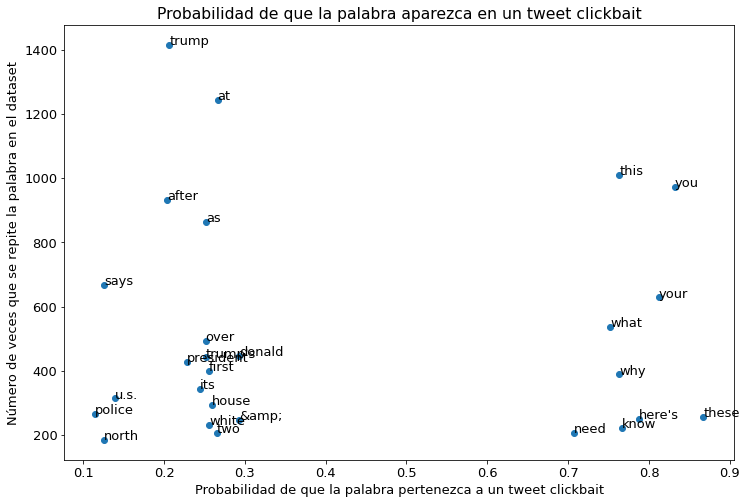

In [10]:
data = data_processing.process_file(default_config['train_dir'], ['postText'])
do_descriptive_analysis(data)

<font color='lightgreen'> Variabilidad de los anotadores </font>

Resulta interesante observar la variación de las puntuaciones del conjunto de anotadores para cada tweet. Esto puede representarse como un diagrama de cajas de la desviación típica de las puntuaciones.

A la vista de los datos, los anotadores no tienen un consenso muy definido entre sus valoraciones, lo cual podría resultar en confusiones a la hora de entrenar la red neuronal. 

Dado que los mayores valores de desviación típica implica que la correspondiente media está relativamente centrada (uno de los dos casos de mayor desviación típica sería el conjunto de puntuaciones [1, 1, 1, 0, 0], con media = 0.6 y desviación típica ~0.49), resulta relativamente seguro eliminar aquellos datos cuya media de las puntuaciones se encuentre cercana a 0.5.

Esto además nos permite descartar tweets con conjuntos de puntuaciones no polarizados, por ejemplo [0.66, 0.66, 0.66, 0.33, 0.33]. Aunque dicho tweet se considere clickbait, el conjunto de los anotadores no tiene certeza de ello, y puede provocar errores de clasificación durante el entrenamiento.

La cantidad de datos a descartar se tomará como un hiperparámetro. Esto puede perjudicar en que hay un menor número de datos que entrenar, por lo que no resulta obvio que vaya a mejorar el modelo. Por lo tanto, la cantidad de datos a descartar se tomará como un hiperparámetro.

*Nota: Esta idea proviene de este proyecto: [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT/blob/main/Final-Report/EECS498NLP_Project_Final_Report.pdf)*, donde aseguran que mejoran las predicciones.



<font color='lightgreen'> Probabilidad de clickbait en función del número de palabras por tweet </font>

A la vista de la gráfica, podemos observar que la mayoría de tweets con un número de palabras muy bajo suele ser clickbait, y dicha probabilidad tiende a reducirse generalizadamente conforme aumenta el número de palabras. 

<font color='lightgreen'> Probabilidad de que la palabra aparezca en un clickbait </font>

Estos resultados no resultan muy reveladores, pero dan pequeñas pistas de qué se puede considerar legítimo y qué puede considerarse clickbait.

Por ejemplo, entre las palabras que más aparecen en los tweets que son clickbaits aparecen apelativos al lector 'you'/'your', preguntas 'what'/'why' y adjetivos demostrativos 'this'/'these'. 

En el caso de tweets legítimos, parece que tiende a poseer palabras menos ambiguas, tales como 'u.s.'/'police'/'trump'/'president'.

Igualmente hay clasificaciones extrañas. Por ejemplo, 'says' se ha catalogado como una palabra que se usa mucho en tweets legítimos, cuando es una palabra que puede recordar a un clickbait.

[Volver al índice](#Index)
<a name=Fine-tuning></a>
# <font color='orange'> Fine-tuning </font>

[Volver al índice](#Index)

<a name='M1'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en BERT </font>

In [ ]:
config_M1 = default_config
config_M1['checkpoint'] = 'bert-base-uncased'
config_M1['model_name'] = default_config['checkpoint'] + '-clickbait'
config_M1['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M1['inputs'] = ['postText']

training(config_M1['train_dir'],config_M1)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 12:38:10,541] A new study created in memory with name: bert-base-uncased-clickbait


 
Prueba 0 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 4.8763889962463215e-05 
epochs: 1 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.423200,0.378992,0.842375,0.721351


[I 2022-04-06 12:40:44,568] Trial 0 finished with value: 0.721351025331725 and parameters: {'learning_rate': 4.8763889962463215e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 0 with value: 0.721351025331725.


 
 F1-score en test 0 = 0.721351025331725 
 Accuracy en test 0 = 0.842374616171955 
 
 
Prueba 1 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.881788274425803e-05 
epochs: 2 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.431700,0.400649,0.827021,0.703335
2,0.303900,0.463157,0.853292,0.718586


[I 2022-04-06 12:45:33,935] Trial 1 finished with value: 0.7185863874345549 and parameters: {'learning_rate': 3.881788274425803e-05, 'epochs': 2, 'batch_size_train': 16}. Best is trial 0 with value: 0.721351025331725.


 
 F1-score en test 1 = 0.7185863874345549 
 Accuracy en test 1 = 0.8532923916751962 
 
 
Prueba 2 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.4185493262948674e-05 
epochs: 2 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.427200,0.401732,0.833845,0.712684
2,0.298200,0.453267,0.852269,0.722614


[I 2022-04-06 12:50:19,617] Trial 2 finished with value: 0.7226137091607943 and parameters: {'learning_rate': 3.4185493262948674e-05, 'epochs': 2, 'batch_size_train': 16}. Best is trial 2 with value: 0.7226137091607943.


 
 F1-score en test 2 = 0.7226137091607943 
 Accuracy en test 2 = 0.8522688502217673 
 
 
Prueba 3 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.968800943614797e-05 
epochs: 3 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.434400,0.416788,0.834869,0.710526
2,0.316600,0.540153,0.852610,0.706522
3,0.196700,0.760798,0.848857,0.691289


[I 2022-04-06 12:57:30,195] Trial 3 finished with value: 0.6912891986062718 and parameters: {'learning_rate': 3.968800943614797e-05, 'epochs': 3, 'batch_size_train': 16}. Best is trial 2 with value: 0.7226137091607943.


 
 F1-score en test 3 = 0.6912891986062718 
 Accuracy en test 3 = 0.8488570453770045 
 


[Volver al índice](#Index)

<a name='M2'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en RoBERTa </font>

In [ ]:
config_M2 = default_config
config_M2['checkpoint'] = 'roberta-base'
config_M2['model_name'] = default_config['checkpoint'] + '-clickbait'
config_M2['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M2['inputs'] = ['postText']

training(config_M2['train_dir'],config_M2)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 13:09:09,068] A new study created in memory with name: roberta-base-clickbait


 
Prueba 0 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 4.0963638314565254e-05 
epochs: 2 
batch_size_train: 32 


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.448300,0.451870,0.852610,0.709677
2,0.327600,0.436942,0.843057,0.702842


[I 2022-04-06 13:13:50,017] Trial 0 finished with value: 0.7028423772609819 and parameters: {'learning_rate': 4.0963638314565254e-05, 'epochs': 2, 'batch_size_train': 32}. Best is trial 0 with value: 0.7028423772609819.


 
 F1-score en test 0 = 0.7028423772609819 
 Accuracy en test 0 = 0.8430569771409075 
 
 
Prueba 1 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 4.09141014526183e-05 
epochs: 1 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.436300,0.390105,0.832139,0.699634


[I 2022-04-06 13:16:11,549] Trial 1 finished with value: 0.6996336996336997 and parameters: {'learning_rate': 4.09141014526183e-05, 'epochs': 1, 'batch_size_train': 32}. Best is trial 0 with value: 0.7028423772609819.


 
 F1-score en test 1 = 0.6996336996336997 
 Accuracy en test 1 = 0.8321392016376663 
 
 
Prueba 2 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 2.14168003397444e-05 
epochs: 3 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.447200,0.436278,0.851928,0.708725
2,0.343100,0.486890,0.851928,0.712583
3,0.272000,0.498258,0.847834,0.703063


[I 2022-04-06 13:22:58,287] Trial 2 finished with value: 0.7030625832223701 and parameters: {'learning_rate': 2.14168003397444e-05, 'epochs': 3, 'batch_size_train': 32}. Best is trial 2 with value: 0.7030625832223701.


 
 F1-score en test 2 = 0.7030625832223701 
 Accuracy en test 2 = 0.8478335039235756 
 
 
Prueba 3 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 3.110030998183404e-05 
epochs: 1 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.410200,0.400335,0.847492,0.715105


[I 2022-04-06 13:25:41,399] Trial 3 finished with value: 0.7151051625239006 and parameters: {'learning_rate': 3.110030998183404e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 3 with value: 0.7151051625239006.


 
 F1-score en test 3 = 0.7151051625239006 
 Accuracy en test 3 = 0.8474923234390993 
 


[Volver al índice](#Index)

<a name='M3'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en XLM-RoBERTa </font>

In [ ]:
config_M3 = default_config
config_M3['checkpoint'] = 'xlm-roberta-base'
config_M3['model_name'] = default_config['checkpoint'] + '-clickbait'
config_M3['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M3['inputs'] = ['postText']

default_config['hp'] = {'learning_rate': [1e-5, 5e-5], 
                        'epochs': [2,4], 
                        'batch_size_train': [16, 32]} 

training(config_M3['train_dir'],config_M3)

[Volver al índice](#Index)

<a name='M4'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en BERT </font>

In [11]:
config_M4 = default_config
config_M4['checkpoint'] = 'bert-base-uncased'
config_M4['n_trials'] = 1
config_M4['inputs'] = ['postText', 'targetKeywords']
default_config['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2], 
                        'batch_size_train': [8]} 

config_M4['model_name'] = default_config['checkpoint'] + '-clickbait-keywords-' + str(i)
config_M4['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
training(config_M4['train_dir'],config_M4)

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 15:28:31,681] A new study created in memory with name: bert-base-uncased-clickbait-keywords-0


 
Prueba 1 de 1 
Hiperparámetros para bert-base-uncased 
learning_rate: 4.217625338135431e-05 
epochs: 2 
batch_size_train: 8 


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.477500,0.418750,0.843739,0.693029
2,0.378600,0.643793,0.857387,0.690370


[W 2022-04-06 15:49:06,876] Trial 0 failed because of the following error: NameError("name 'torch' is not defined")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/content/ClickbaitDetector/utils/Objective.py", line 91, in __call__
    torch.cuda.empty_cache()
NameError: name 'torch' is not defined


 
 F1-score para datos de validación en test 1 = 0.6903703703703702 
 Accuracy para datos de validación en test 1 = 0.8573865574889117 
 


NameError: ignored

[Volver al índice](#Index)

<a name='M5'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en RoBERTa </font>

In [ ]:
config_M5 = default_config
config_M5['checkpoint'] = 'roberta-base'
config_M5['model_name'] = default_config['checkpoint'] + '-clickbait-keywords'
config_M5['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M5['inputs'] = ['postText', 'targetKeywords']

training(config_M5['train_dir'],config_M5)

[Volver al índice](#Index)

<a name='M6'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en XLM-RoBERTa </font>

In [ ]:
config_M6 = default_config
config_M6['checkpoint'] = 'xlm-roberta-base'
config_M6['model_name'] = default_config['checkpoint'] + '-clickbait-keywords'
config_M6['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M6['inputs'] = ['postText', 'targetKeywords']

training(config_M6['train_dir'],config_M6)

[Volver al índice](#Index)

<a name='M7'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetParagraph' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en Longformer </font>

In [ ]:
config_M7 = default_config
config_M7['checkpoint'] = 'roberta-base'
config_M7['model_name'] = default_config['checkpoint'] + '-clickbait-paragraph'
config_M7['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M7['inputs'] = ['postText']

training(config_M7['train_dir'],config_M7)

[Volver al índice](#Index)
<a name=errors></a>
# <font color='orange'> Análisis de errores </font>

[Volver al índice](#Index)
<a name=Otros></a>
# <font color='orange'> Otras funciones </font>

<font color='lightgreen'> Subir checkpoint a HuggingFace </font>

In [ ]:
!pip install huggingface_hub -q
!sudo apt-get install git-lfs -q

!huggingface-cli login

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
def push_model_to_hub(dir, name):
  model = AutoModelForSequenceClassification.from_pretrained(
              dir, num_labels=2, return_dict=True)
  tokenizer = AutoTokenizer.from_pretrained(dir)

  model.push_to_hub(name, use_temp_dir=True)
  tokenizer.push_to_hub(name, use_temp_dir=True)

In [ ]:
push_model_to_hub(config_M3['finetuned_model_dir'], 'M3 ')

<font color='lightgreen'> Liberar cache GPU </font>

In [14]:
torch.cuda.empty_cache()